## Introduction

Is school performance predicted by socioeconomic factors? This notebook cleans and analyses data to answer this question.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Feature selection
from itertools import combinations
import statsmodels.api as sm

# Ridge regression model
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Clean data

### The data

This project utilizes three data sets. The first data set is the EdGap data set from [EdGap.org](https://www.edgap.org/#5/37.875/-96.987). This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district. The second data set is basic information about each school from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). The third data set is additional economic [Census data](https://www.census.gov/data/tables/2019/econ/school-finances/secondary-education-finance.html).





#### EdGap data

All socioeconomic data (household income, unemployment, adult educational attainment, and family structure) are from the Census Bureau's American Community Survey.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) report that ACT and SAT score data is from each state's department of education or some other public data release. The nature of the other public data release is not known.

The quality of the census data and the department of education data can be assumed to be reasonably high.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) do not indicate that they processed the data in any way. The data were assembled by the [EdGap.org](https://www.edgap.org/#5/37.875/-96.987) team, so there is always the possibility for human error. Given the public nature of the data, we would be able to consult the original data sources to check the quality of the data if we had any questions.

#### School information data

The school information data is from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). This data set consists of basic identifying information about schools and can be assumed to be of reasonably high quality. As for the EdGap.org data, the school information data is public, so we would be able to consult the original data sources to check the quality of the data if we had any questions.


#### Census data

An additional data set was gathered from the [Census website](https://www.census.gov/data/tables/2019/econ/school-finances/secondary-education-finance.html). The data set contains information about various financial metrics for public schools such as average teacher salary per student. The data set is from the year 2019, which is close enough to the other data sets given the slow rate at which these metrics are expected to change.

### Load the data

Load the EdGap
 data set

In [3]:
edgap = pd.read_excel('https://github.com/Tres300/Education-Inequality/raw/main/EdGap_data.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Load the school information data

In [4]:
!wget -O school_info.csv https://drive.usercontent.google.com/u/0/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP&export=download

--2024-05-06 18:58:53--  https://drive.usercontent.google.com/u/0/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.125.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP [following]
--2024-05-06 18:58:53--  https://drive.usercontent.google.com/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP [following]
--2024-05-06 18:58:53--  https://drive.usercontent.google.com/download?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, await

In [5]:
school_info = pd.read_csv('school_info.csv', encoding= 'unicode_escape')

<ipython-input-5-9aca6f144c98>:1: DtypeWarning: Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  school_info = pd.read_csv('school_info.csv', encoding= 'unicode_escape')


In [8]:
census = pd.read_csv('https://github.com/Tres300/Education-Inequality/raw/main/school_census_data.csv')

<ipython-input-8-dca38f579076>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  census = pd.read_csv('https://github.com/Tres300/Education-Inequality/raw/main/school_census_data.csv')


### Rename columns

Rename the columns `NCESSCH School ID`, `CT Pct Adults with College Degree`,`CT Unemployment Rate`, `CT Pct Childre In Married Couple Family`, `CT Median Household Income`, `School ACT average (or equivalent if SAT score)`, `School Pct Free and Reduced Lunch` to `id`, `percent_college`, `rate_unemployment`, `percent_married`, `median_income`, `average_act`, `percent_lunch`

In [9]:
edgap = edgap.rename(columns={"NCESSCH School ID":"id",
              "CT Pct Adults with College Degree":"percent_college",
              "CT Unemployment Rate":"rate_unemployment",
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

Rename the columns `SCHOOL_YEAR`, `NCESSCH`, `MSTATE`, `MZIP`, `SCH_TYPE_TEXT`, `LEVEL` to `year`, `id`, `state`, `zip_code`, `school_type`, `school_level`

In [10]:
school_info = school_info.rename(columns={"SCHOOL_YEAR":"year",
              "NCESSCH":"id",
              "MSTATE":"state",
              "MZIP":"zip_code",
              "SCH_TYPE_TEXT":"school_type",
              "LEVEL":"school_level"})

Rename the columns `NCESID`, `PPISALWG`, `PPSTOTAL`, `PPSSTAFF`, `PPSGENAD` to `district_id`, `teacher_salary`, `student_support`, `staff_support`, `admin_salary`

In [11]:
census = census.rename(columns={"NCESID":"district_id",
              "PPISALWG":"teacher_salary",
              "PPSTOTAL":"student_support",
              "PPSSTAFF":"staff_support",
              "PPSGENAD":"admin_salary"})

### Explore the contents of the data sets

#### Edgap

In [12]:
edgap

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641
...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583


In [13]:
edgap.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
count,7.986000e+03,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000
mean,3.321869e+11,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651
std,1.323638e+11,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545
25%,2.105340e+11,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501
50%,3.600085e+11,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570
75%,4.226678e+11,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447
max,5.605830e+11,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729


It seems we have some negative average_act and percent_lunch values, which isn't possible. We also have at least one 0.0 for percent_married and at least one 1.0 for percent_college and percent_married. These values aren't impossible, but improbable.

In [14]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   int64  
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB


#### School info

In [15]:
school_info

,year,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,...,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,school_level,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoyah Sch - Chalkville Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
1,2016-2017,1,ALABAMA,AL,Camps,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
3,2016-2017,1,ALABAMA,AL,Wallace Sch - Mt Meigs Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
4,2016-2017,1,ALABAMA,AL,McNeel Sch - Vacca Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102178,2016-2017,78,U.S. VIRGIN ISLANDS,VI,GLADYS A. ABRAHAM ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102179,2016-2017,78,U.S. VIRGIN ISLANDS,VI,ULLA F MULLER ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102180,2016-2017,78,U.S. VIRGIN ISLANDS,VI,YVONNE BOWSKY ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102181,2016-2017,78,U.S. VIRGIN ISLANDS,VI,CANCRYN JUNIOR HIGH SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,07,08,Middle,As reported


In [16]:
school_info.describe()

,FIPST,UNION,id,SCHID
count,102183.000000,2533.000000,1.021810e+05,1.021810e+05
mean,29.018496,207.158310,2.913297e+11,2.904893e+06
std,16.844778,125.767108,1.684048e+11,1.684249e+06
min,1.000000,1.000000,1.000020e+10,1.000010e+05
25%,13.000000,50.000000,1.302550e+11,1.302169e+06
50%,29.000000,300.000000,2.911250e+11,2.900753e+06
75%,42.000000,300.000000,4.220250e+11,4.206624e+06
max,78.000000,301.000000,7.800030e+11,7.800037e+06


In [17]:
school_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  id                   102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

The data is of reasonably high quality. Arguably the school year could be converted to a data time, or a variable for ordering of school years could be useful in some contexts, but since the data present is only from the 2016-2017 school year I don't think it is necessary.

#### Census

In [18]:
census

,IDCENSUS,NAME,CONUM,CSA,CBSA,district_id,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,...,PPSALWG,PPEMPBEN,PPITOTAL,teacher_salary,PPIEMBEN,student_support,PPSPUPIL,staff_support,admin_salary,PPSSCHAD
0,1500100100000,AUTAUGA COUNTY SCHOOL DISTRICT,1001,N,33860,0100240,9094,88218,7798,2071,...,5001,2088,5100,3357,1311,2885,512,241,184,551
1,1500200100000,BALDWIN COUNTY SCHOOL DISTRICT,1003,380,19300,0100270,32267,397613,27518,7240,...,5621,2178,5922,3665,1381,3617,620,396,152,653
2,1500300100000,BARBOUR COUNTY SCHOOL DISTRICT,1005,N,21640,0100300,755,9978,2276,1180,...,6873,2736,6211,3816,1523,5192,518,474,893,975
3,1500300200000,EUFAULA CITY SCHOOL DISTRICT,1005,N,21640,0101410,5427,42232,4346,1335,...,2877,1161,3067,1863,740,1867,321,151,179,397
4,1500400100000,BIBB COUNTY SCHOOL DISTRICT,1007,142,13820,0100360,3236,34923,3889,1046,...,5500,2242,5265,3361,1297,3861,656,504,390,648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195,51502100400000,UINTA CO SCH DIST 6,56041,N,21740,5604260,727,14180,633,131,...,10157,4392,8365,5367,2248,8351,2296,913,355,779
14196,51502200300000,WASHAKIE SCH DIST 2,56043,N,N,5605820,108,3517,108,11,...,15528,8324,16324,9500,5231,11889,343,954,2861,1296
14197,51502200400000,WASHAKIE CO SCH DIST 1,56043,N,N,5606240,1272,25698,1731,499,...,9614,4524,10577,6407,3044,6002,1036,646,399,1083
14198,51502300100000,WESTON CO SCH DIST 1,56045,N,N,5604830,792,14791,1261,419,...,10331,4013,9881,6635,2477,6987,789,996,415,874


In [19]:
census.describe()

,IDCENSUS,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,FEDRSPEC,FEDRNUTR,FEDROTHR,TSTREV,STRFORM,...,PPSALWG,PPEMPBEN,PPITOTAL,teacher_salary,PPIEMBEN,student_support,PPSPUPIL,staff_support,admin_salary,PPSSCHAD
count,1.420000e+04,14200.000000,1.420000e+04,1.420000e+04,14200.000000,14200.000000,14200.000000,14200.000000,1.420000e+04,1.420000e+04,...,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000,14200.000000
mean,2.707694e+13,3381.123239,5.376962e+04,4.075983e+03,990.789577,828.052606,1171.121197,1086.019859,2.471219e+04,1.662687e+04,...,7805.764718,3444.995352,8218.243028,5122.144366,2254.965000,5472.731620,809.745493,616.391761,623.388380,750.068028
std,1.383486e+13,13899.109109,3.314156e+05,2.372530e+04,7533.934232,5011.268813,6710.899838,5854.991827,1.308720e+05,9.073064e+04,...,9538.155120,4782.000923,7289.602870,4207.457632,2223.698226,11515.353278,3891.727202,2755.315081,1673.900794,949.892995
min,1.500100e+12,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.550275e+13,309.000000,6.136000e+03,3.310000e+02,59.000000,0.000000,73.750000,60.000000,2.584250e+03,1.356500e+03,...,5717.000000,1874.000000,5977.000000,3813.000000,1238.750000,3494.000000,331.000000,225.000000,217.000000,520.750000
50%,2.750197e+13,986.000000,1.637300e+04,9.315000e+02,194.000000,143.000000,242.000000,176.000000,7.647500e+03,4.831000e+03,...,6857.500000,2923.000000,7263.000000,4604.000000,1929.000000,4401.500000,556.000000,414.000000,390.000000,668.000000
75%,3.750670e+13,2736.250000,4.404800e+04,2.680000e+03,587.250000,585.250000,744.000000,612.000000,1.946775e+04,1.248125e+04,...,8750.000000,4305.500000,9490.000000,5864.250000,2911.000000,5972.000000,876.000000,665.000000,688.000000,874.000000
max,5.150230e+13,960484.000000,3.378851e+07,1.959483e+06,637844.000000,469057.000000,500242.000000,352340.000000,1.185299e+07,8.336719e+06,...,636022.000000,346826.000000,459283.000000,263065.000000,147500.000000,715739.000000,377870.000000,186143.000000,84000.000000,74435.000000


In [20]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14200 entries, 0 to 14199
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IDCENSUS         14200 non-null  int64  
 1   NAME             14200 non-null  object 
 2   CONUM            14200 non-null  object 
 3   CSA              14200 non-null  object 
 4   CBSA             14200 non-null  object 
 5   district_id      14200 non-null  object 
 6   ENROLL           14200 non-null  int64  
 7   TOTALREV         14200 non-null  int64  
 8   TFEDREV          14200 non-null  int64  
 9   FEDRCOMP         14200 non-null  int64  
 10  FEDRSPEC         14200 non-null  int64  
 11  FEDRNUTR         14200 non-null  int64  
 12  FEDROTHR         14200 non-null  int64  
 13  TSTREV           14200 non-null  int64  
 14  STRFORM          14200 non-null  int64  
 15  STRSPEC          14200 non-null  int64  
 16  STRTRANS         14200 non-null  int64  
 17  STROTHR     

This is a large, high-quality data set with many different numeric variables that can be used as features.

### Convert data types

Drop NaN all `id` before converting them to their district_id.

In [21]:
school_info = school_info.dropna(subset=['id'])

Convert `id` to `district_id`

In [22]:
school_info.loc[:,'district_id'] = school_info['id'].astype(str).str[0:7].str.zfill(7)
school_info[['id','district_id']]

<ipython-input-22-f17a9abe91ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info.loc[:,'district_id'] = school_info['id'].astype(str).str[0:7].str.zfill(7)


,id,district_id
0,1.000020e+10,1000020
1,1.000020e+10,1000020
2,1.000020e+10,1000020
3,1.000020e+10,1000020
4,1.000020e+10,1000020
...,...,...
102178,7.800030e+11,7800030
102179,7.800030e+11,7800030
102180,7.800030e+11,7800030
102181,7.800030e+11,7800030


Set `id` in school_info to type int64, the same as `id` in edgap.

In [23]:
school_info.loc[:, 'id'] = school_info['id'].astype('int64')

Convert `zip_code` to an object since it shouldn't be interpreted an quantitative.

In [24]:
school_info.loc[:,'zip_code'] = school_info['zip_code'].astype('str').str.zfill(5)

A merge will take place later between school_info and census on `district_id`, and both are of type 'object'.

### Quality Control

Check for out-of-range values or values that do not match what we want to analyze. Either set values to `NaN` or remove the observations, as appropriate.

In [25]:
# List all the rows with a negative average_act or percent_lunch
edgap[(edgap.average_act < 0) | (edgap.percent_lunch < 0)]

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
1398,173897003956,0.160519,0.673671,0.554577,68924.0,16.500000,-0.004777
1422,174098004105,0.040594,0.789430,0.831663,69466.0,21.400000,-0.007792
2336,250279000217,0.027694,0.955152,1.000000,111923.0,16.025641,-0.022670
2514,251104001774,0.051298,0.588981,0.795222,50530.0,22.545788,-0.026866
2718,260807004379,0.154488,0.545110,0.772984,43750.0,18.700000,-0.017241
3277,291254000516,0.159223,0.494906,0.538893,35299.0,21.200000,-0.015986
3519,293180002224,0.067823,0.555265,0.675737,64603.0,21.300000,-0.037815
3773,341269003101,0.153491,0.284550,0.329727,23783.0,-3.070818,0.796380
3776,341269003107,0.126452,0.321543,0.253482,31563.0,-3.070818,0.847015
3777,341269003109,0.060403,0.344922,0.138728,25000.0,-3.070818,0.837104


In [26]:
# Convert these invalid values to NaN
edgap[(edgap.average_act < 0) | (edgap.percent_lunch < 0)] = pd.NA

In [27]:
# Drop rows with NaN id or average_act
edgap.dropna(subset=['id', 'average_act'], inplace=True)

Since the id NaN values can't be imputed, they should be dropped. average_act shouldn't be imputed as it is the target for prediction.

In [28]:
# Count how many nans there are
edgap.isna().sum().sum()

72

There are relatively few nans compared to the number of rows (almost 8000) in our data set. We could drop them without much worry, but we'll impute them later.

### Select relevant subsets of the data

The school information data set contains a lot of information. We only need the columns `year`, `id`, `district_id`, `state`, `zip_code`, `school_type`, `school_level` from the school_info dataset.


In [29]:
# Get a list of all the columns that need to be dropped in school_info
good_columns = ['year', 'id', 'district_id', 'state', 'zip_code', 'school_type', 'school_level']
all_columns = list(school_info.columns)
bad_columns = []
for column in all_columns:
  if column not in good_columns:
    bad_columns.append(column)
school_info.drop(columns=bad_columns, inplace=True)

<ipython-input-29-06221ec6736c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info.drop(columns=bad_columns, inplace=True)


In [30]:
school_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102181 entries, 0 to 102182
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          102181 non-null  object 
 1   id            102181 non-null  float64
 2   state         102181 non-null  object 
 3   zip_code      102181 non-null  object 
 4   school_type   102179 non-null  object 
 5   school_level  102179 non-null  object 
 6   district_id   102181 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.2+ MB


We only need the columns `district_id`, `teacher_salary`, `student_support`, `staff_support`, `admin_salary` from the census dataset.

In [31]:
# Get a list of all the columns that need to be dropped in census
good_columns = ['district_id', 'teacher_salary', 'student_support', 'staff_support', 'admin_salary']
all_columns = list(census.columns)
bad_columns = []
for column in all_columns:
  if column not in good_columns:
    bad_columns.append(column)
census.drop(columns=bad_columns, inplace=True)

In [32]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14200 entries, 0 to 14199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   district_id      14200 non-null  object
 1   teacher_salary   14200 non-null  int64 
 2   student_support  14200 non-null  int64 
 3   staff_support    14200 non-null  int64 
 4   admin_salary     14200 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 554.8+ KB


### Join data frames
Perform an inner join on 'id' in edgap and 'id' in school_info.

In [33]:
df = edgap.merge(school_info, on='id')

In [34]:
# Use 'id' to find the equivalent 'district_id'
df['district_id'] = df['id'].astype(str).str[0:7].str.zfill(7)

In [35]:
print("Rows lost during join: {}".format(edgap.shape[0]-df.shape[0]))

Rows lost during join: 88


It looks like we lost a few rows during the join, meaning either the info for an id in edgap was not in school_info or vice-versa. This has the added benefit of drastically decreaing the likelihood of an invalid id, since it has to also exist in school_info. The number of rows lost is very small, so this is totally fine.

Perform an inner join on 'district_id' in df and 'district_id' in census.

In [36]:
old_len = df.shape[0]
df = df.merge(census, on='district_id')

In [37]:
print("Rows lost during join: {}".format(old_len-df.shape[0]))

Rows lost during join: 622


We lost more rows during this join, but relatively few compared to the number of rows remaining.

In [38]:
df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,district_id,teacher_salary,student_support,staff_support,admin_salary
0,1.000080e+11,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,1000080,5201,4474,67,236
1,1.000080e+11,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,1000080,5201,4474,67,236
2,1.000170e+11,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,1000170,5368,4501,230,180
3,1.000180e+11,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,1000180,5403,4676,192,153
4,1.000190e+11,0.080120,0.673492,0.483333,50649.0,17.034188,0.425118,2016-2017,DE,19904,Regular School,High,1000190,6440,5128,123,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,5.605302e+11,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156,2016-2017,WY,82902,Regular School,High,5605302,5688,5671,757,344
7249,5.605690e+11,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871,2016-2017,WY,82833,Regular School,High,5605690,5007,6481,785,518
7250,5.605695e+11,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829,2016-2017,WY,82801,Regular School,High,5605695,5646,5202,786,337
7251,5.605762e+11,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583,2016-2017,WY,82935,Regular School,High,5605762,6053,6689,610,349


#### Check for duplicate ids

In [39]:
len(df['id']) - len(df['id'].unique())

0

There are none! Hooray!

#### Drop district_id

We don't need district_id anymore after merging. Drop it for cleanliness sake.

In [40]:
df.drop(columns=['district_id'], inplace=True)

### Identify missing values

Determine whether there are missing values in the data set.

In [41]:
missing = df.isna().sum()
missing

id                    0
rate_unemployment    12
percent_college      11
percent_married      19
median_income        16
average_act           0
percent_lunch         0
year                  0
state                 0
zip_code              0
school_type           0
school_level          0
teacher_salary        0
student_support       0
staff_support         0
admin_salary          0
dtype: int64

In [42]:
missing.sum()

58

There are 58 NaNs. Some imputation will need to be done to those after the train test split.

### Train test split

We will use the test set approach to compare models predicting `average_act`.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/ML_dataset_training_validation_test_sets.png/800px-ML_dataset_training_validation_test_sets.png)

Split the data into training and testing sets. Keep 20% of the data for the test set.

In [43]:
train_df, test_df = train_test_split(df,shuffle = True, test_size = 0.2, random_state=17)

### Data imputation

 Section to use an imputation method to replace missing values in the columns corresponding to predictor variables in the analysis.

In [44]:
variables_to_impute = ['rate_unemployment','percent_college','percent_married','median_income']

In [45]:
X = train_df[variables_to_impute]
imputer = IterativeImputer()
imputer.fit(X)
train_df[variables_to_impute] = imputer.transform(X)

In [46]:
X = test_df[variables_to_impute]
test_df[variables_to_impute] = imputer.transform(X)

### Normalize Data

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7253 non-null   float64
 1   rate_unemployment  7241 non-null   float64
 2   percent_college    7242 non-null   float64
 3   percent_married    7234 non-null   float64
 4   median_income      7237 non-null   float64
 5   average_act        7253 non-null   float64
 6   percent_lunch      7253 non-null   float64
 7   year               7253 non-null   object 
 8   state              7253 non-null   object 
 9   zip_code           7253 non-null   object 
 10  school_type        7253 non-null   object 
 11  school_level       7253 non-null   object 
 12  teacher_salary     7253 non-null   int64  
 13  student_support    7253 non-null   int64  
 14  staff_support      7253 non-null   int64  
 15  admin_salary       7253 non-null   int64  
dtypes: float64(7), int64(4),

average_act is excluded from numeric_features because it is the target.

In [48]:
numeric_features = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch', 'teacher_salary', 'student_support', 'staff_support', 'admin_salary']

In [49]:
train_df_mean = train_df[numeric_features].mean()

In [50]:
train_df_std = train_df[numeric_features].std()

In [51]:
train_df[numeric_features] = (train_df[numeric_features] - train_df_mean) / train_df_std

In [52]:
test_df[numeric_features] = (test_df[numeric_features] - train_df_mean) / train_df_std

### Create relevant derived variables as new columns

### Export the clean .csv files

Export files with the training and testing data.

The following code exports each clean data set to a csv, and then copies it into the user's google drive.

In [53]:
train_df.to_csv('clean_edu_ineq_normalized_train.csv', index=False)

In [54]:
test_df.to_csv('clean_edu_ineq_normalized_test.csv', index=False)

In [55]:
train_df_mean.to_csv('clean_edu_ineq_train_mean.csv', index=False)

In [56]:
train_df_std.to_csv('clean_edu_ineq_train_std.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('drive')

In [58]:
!cp clean_edu_ineq_normalized_train.csv "drive/My Drive/"

In [59]:
!cp clean_edu_ineq_normalized_test.csv "drive/My Drive/"

In [60]:
!cp clean_edu_ineq_train_mean.csv "drive/My Drive/"

In [61]:
!cp clean_edu_ineq_train_std.csv "drive/My Drive/"

## Questions

The following are the questions that will be attempted to be answered by this notebook:
* Is school performance predicted by socioeconomic factors?
* Can average ACT scores be predicted using linear regression?


## Analysis

In [62]:
train_df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,teacher_salary,student_support,staff_support,admin_salary
5400,4.701080e+11,-0.525862,0.422496,0.591482,-0.221715,21.700000,0.666773,2016-2017,TN,38024,Regular School,High,-0.184375,-0.822841,-0.497719,0.428302
4059,3.704720e+11,0.554634,1.288955,0.020599,-0.309879,22.570208,-0.576851,2016-2017,NC,27609,Regular School,High,-0.154156,-1.011689,-0.896989,-0.903272
6829,5.310110e+11,-0.485847,0.436574,-0.272440,-0.404603,18.956044,1.028268,2016-2017,WA,98908,Regular School,High,0.590459,0.180975,1.288844,-0.499163
1974,2.105820e+11,0.389282,-1.068060,1.142029,-0.454409,18.500000,0.061965,2016-2017,KY,42409,Regular School,High,-1.168413,-0.213998,0.118104,0.136813
154,1.200390e+11,-0.285580,1.137102,0.780774,0.423136,18.369963,0.753893,2016-2017,FL,33196,Regular School,High,-1.076208,-0.909818,-0.118751,-0.896647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,1.734380e+11,1.229910,0.063087,-1.792098,-0.808444,19.500000,0.568736,2016-2017,IL,61071,Regular School,High,0.346386,1.095430,-0.436814,5.353803
406,1.201590e+11,0.555590,-1.338158,-0.492486,-0.507475,18.980464,0.561126,2016-2017,FL,33839,Regular School,High,-1.094029,-0.927094,0.087651,-0.837025
5510,4.703000e+11,1.923895,-0.851070,0.036420,-0.752872,18.200000,0.288810,2016-2017,TN,37354,Regular School,High,-0.705837,-0.778160,-0.230411,-0.485913
2191,2.201740e+11,-1.147887,-0.572701,0.087441,0.080759,19.800000,0.109428,2016-2017,LA,70360,Regular School,High,-0.862354,-0.399868,0.456468,-0.681343


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5802 entries, 5400 to 2671
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5802 non-null   float64
 1   rate_unemployment  5802 non-null   float64
 2   percent_college    5802 non-null   float64
 3   percent_married    5802 non-null   float64
 4   median_income      5802 non-null   float64
 5   average_act        5802 non-null   float64
 6   percent_lunch      5802 non-null   float64
 7   year               5802 non-null   object 
 8   state              5802 non-null   object 
 9   zip_code           5802 non-null   object 
 10  school_type        5802 non-null   object 
 11  school_level       5802 non-null   object 
 12  teacher_salary     5802 non-null   float64
 13  student_support    5802 non-null   float64
 14  staff_support      5802 non-null   float64
 15  admin_salary       5802 non-null   float64
dtypes: float64(11), object(5)


In [64]:
train_df_numeric = train_df.select_dtypes(include=['float64'])
train_df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5802 entries, 5400 to 2671
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5802 non-null   float64
 1   rate_unemployment  5802 non-null   float64
 2   percent_college    5802 non-null   float64
 3   percent_married    5802 non-null   float64
 4   median_income      5802 non-null   float64
 5   average_act        5802 non-null   float64
 6   percent_lunch      5802 non-null   float64
 7   teacher_salary     5802 non-null   float64
 8   student_support    5802 non-null   float64
 9   staff_support      5802 non-null   float64
 10  admin_salary       5802 non-null   float64
dtypes: float64(11)
memory usage: 543.9 KB


In [65]:
test_df_numeric = test_df.select_dtypes(include=['float64'])

In [66]:
train_df_numeric.drop(columns=['id'], inplace=True)

In [67]:
test_df_numeric.drop(columns=['id'], inplace=True)

In [68]:
train_df_numeric.corr()

,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,teacher_salary,student_support,staff_support,admin_salary
rate_unemployment,1.000000,-0.412360,-0.553828,-0.471399,-0.425664,0.472234,-0.086645,0.028318,0.085959,-0.015898
percent_college,-0.412360,1.000000,0.429350,0.699993,0.480730,-0.493215,0.268250,0.133986,0.119604,-0.078748
percent_married,-0.553828,0.429350,1.000000,0.627944,0.433666,-0.523859,0.132220,0.004694,-0.108060,0.021829
median_income,-0.471399,0.699993,0.627944,1.000000,0.487094,-0.546435,0.362187,0.186285,0.089173,-0.057149
average_act,-0.425664,0.480730,0.433666,0.487094,1.000000,-0.772956,0.190166,-0.011402,-0.082028,-0.056635
percent_lunch,0.472234,-0.493215,-0.523859,-0.546435,-0.772956,1.000000,-0.164159,-0.010080,0.145719,0.006295
teacher_salary,-0.086645,0.268250,0.132220,0.362187,0.190166,-0.164159,1.000000,0.722507,0.434480,0.184714
student_support,0.028318,0.133986,0.004694,0.186285,-0.011402,-0.010080,0.722507,1.000000,0.577317,0.479786
staff_support,0.085959,0.119604,-0.108060,0.089173,-0.082028,0.145719,0.434480,0.577317,1.000000,-0.000975
admin_salary,-0.015898,-0.078748,0.021829,-0.057149,-0.056635,0.006295,0.184714,0.479786,-0.000975,1.000000


### Regression

#### Feature Selection
Perform best subset selection to find the best features.

In [69]:
def best_subset_selection(X, y):
    """ This function returns AIC, BIC, and adjusted R-squared values for use in best subset selection.

    Inputs
    ------
    X : array-like, shape (n_samples, n_features)
        Predictor values

    y : array-like, shape (n_samples, )
        Target values

    Returns
    ------
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the AIC, BIC, and adjusted r-squared for the best model
    # at each number of predictors
    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors
    best_predictors = list()

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit()

            # Initialize the best values with the first model
            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            # If a model has a better r-squared, update the best values
            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        # Record the values for the best model at this number of predictors
        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

In [70]:
# Separate features and target
train_X = train_df_numeric.loc[:, train_df_numeric.columns != 'average_act']
train_y = train_df_numeric.loc[:,'average_act']

In [71]:
results = best_subset_selection(train_X,train_y)

In [72]:
best_aic, best_bic, best_adjusted_rsquared, best_predictors = results

In [73]:
# Plot the results of best subset selection
def plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors):
    """ Plot the best AIC, BIC, and adjusted R-squared values at each number of possible predictors

    Input
    -----
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    number_predictors = np.arange(len(best_aic))+1

    plt.subplots(1,3, figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(number_predictors, best_aic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_aic)], np.min(best_aic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('AIC', fontsize=18)

    plt.subplot(1,3,2)
    plt.plot(number_predictors, best_bic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_bic)], np.min(best_bic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('BIC', fontsize=18)

    plt.subplot(1,3,3)
    plt.plot(number_predictors, best_adjusted_rsquared, 'b-o');
    plt.plot(number_predictors[np.argmax(best_adjusted_rsquared)], np.max(best_adjusted_rsquared), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('Adjusted R-squared', fontsize=18)

    plt.subplots_adjust(wspace = 0.3)

In [74]:
# best_predictors is a list of the best n features at index n-1.
# Get the best predictors when using 6 features.
best_predictors[5]

('rate_unemployment',
 'percent_college',
 'percent_lunch',
 'teacher_salary',
 'student_support',
 'staff_support')

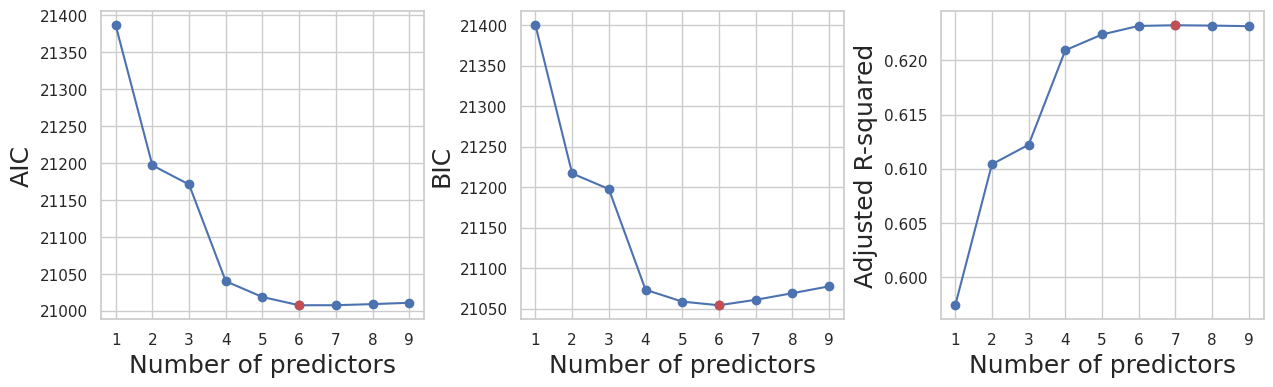

In [75]:
plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors)

6 predictors looks to be ideal as 6 results in the smallest AIC and BIC, with a relatively identical adjusted r-squared to 6 through 9 predictors. The best features to use for 6 predictors are:
 `rate_unemployment`, `percent_college`, `percent_lunch`, `teacher_salary`, `student_support`, `staff_support`

In [76]:
best_features = ['rate_unemployment', 'percent_college', 'percent_lunch', 'teacher_salary', 'student_support', 'staff_support']

#### Train model
Train the model using best_features many times with randomly selected alpha values and pick the model that results in the smallest mean-squared error. A ridge regression model has been picked as it is a good model, it minimizes coefficients, and does not try to minimize the number of features (feature selection has already been done).

In [77]:
train_X = train_df_numeric[best_features]

In [78]:
test_X = test_df_numeric[best_features]

In [79]:
test_y = test_df.loc[:, 'average_act']

In [80]:
# Create 100 different ridge regression models with randomly selected alpha values.
# Returns a tuple of (best_ridge_model, best_mse, best_alpha, best_pred_y)
def rand_find_good_alpha(train_X, train_y):
  best_ridge_model = None
  best_mse = None
  best_alpha = None
  best_pred_y = None
  for a in np.random.choice(np.linspace(.01,.1,1000),100):
    ridge = Ridge(alpha=a)
    ridge.fit(train_X, train_y)
    pred_y = ridge.predict(train_X)
    mse = mean_squared_error(train_y, pred_y)
    if best_mse is None or mse < best_mse:
      best_mse = mse
      best_ridge_model = ridge
      best_alpha = a
      best_pred_y = pred_y
  return (best_ridge_model, best_mse, best_alpha, best_pred_y)

In [83]:
best_ridge_model, best_mse, best_alpha, best_pred_y = rand_find_good_alpha(train_X, train_y)

In [84]:
# Best (smallest) mean-squared error found
best_mse

2.1823919424169516

In [85]:
# Best alpha value used
best_alpha

0.01018018018018018

#### Plot regression results
Plot the actual vs. predicted values of the final model against the training data, then the testing data.

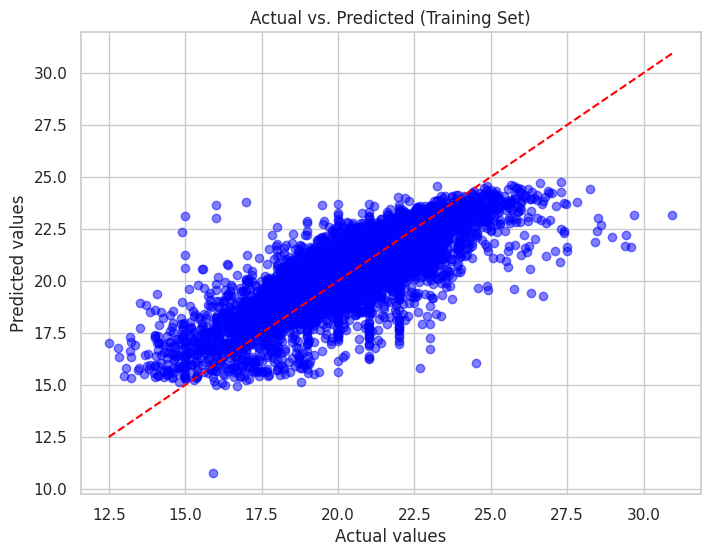

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y, best_pred_y, color='blue', alpha=0.5)
plt.plot([min(train_y), max(train_y)], [min(train_y), max(train_y)], color='red', linestyle='--')
plt.title('Actual vs. Predicted (Training Set)')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

In [87]:
pred_y_test = best_ridge_model.predict(test_X)

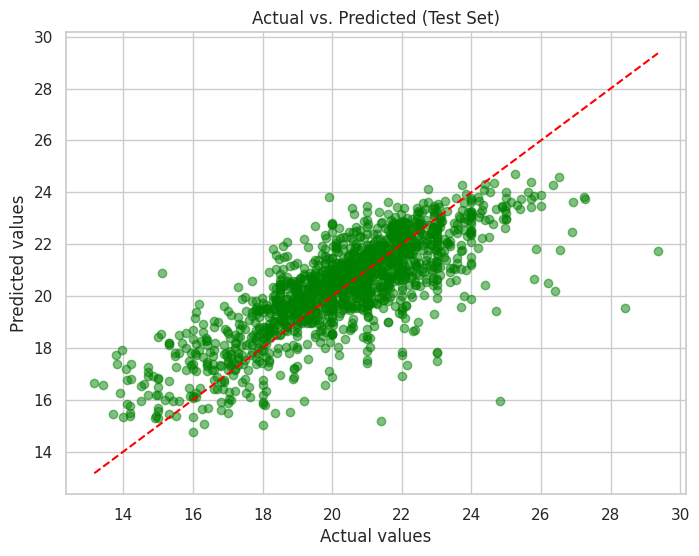

In [88]:
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred_y_test, color='green', alpha=0.5)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red', linestyle='--')
plt.title('Actual vs. Predicted (Test Set)')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

In [89]:
print("Mean-squared error on the testing data:")
print(mean_squared_error(test_y, pred_y_test))

Mean-squared error on the testing data:
2.1182737724667415


## Conclusion

A mean-squared error of about 2.12 means the model's predictions are off by an average of 2.12 ACT "points". With a mean-squared error of less than 2.12 then, average ACT scores can be fairly accurately predicted by the following features:  
* `rate_unemployment` - The percentage of unemployed adults.
* `percent_college` - The percentage of adults with a college degree.
* `percent_lunch` - The percentage of students who received discounted or free lunches.
* `teacher_salary` - The average teacher salary/wage per student.
* `student_support` - The total current spending for support services per student.
* `staff_support` - Instructional staff support per student.

With such a low mean-squared error, this is enough to conclude that school performance is in fact predicted by socioeconomic factors.